<a href="https://colab.research.google.com/github/tejash09/K-means/blob/main/reserach_kmeansv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of iterations: 3
Final inertia: 2221.66
Number of stable points: 999


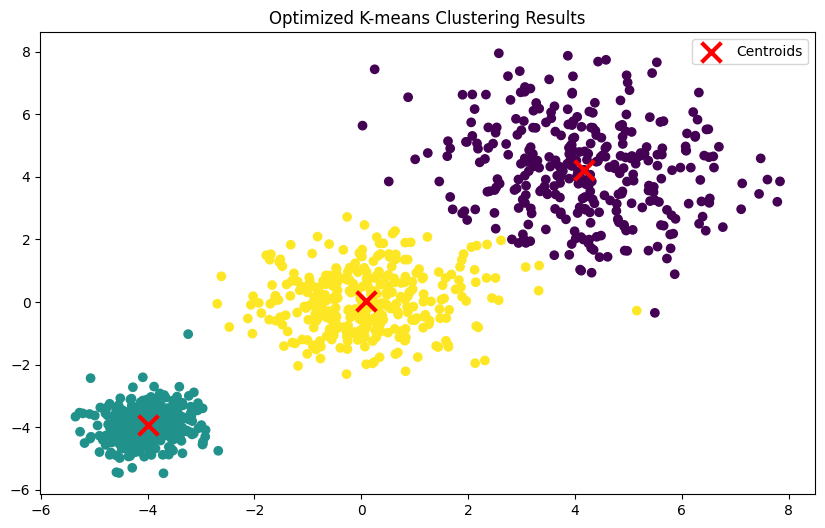

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class OptimizedKMeans(BaseEstimator, ClusterMixin):
    """
    Optimized K-means clustering algorithm that tracks stable points to reduce computations.

    Parameters:
    -----------
    n_clusters : int, default=8
        The number of clusters to form.
    max_iterations : int, default=300
        Maximum number of iterations for a single run.
    tolerance : float, default=1e-4
        Tolerance for centroid change to declare convergence.
    random_state : int or None, default=None
        Random seed for centroid initialization.
    stable_point_check_interval : int, default=5
        Number of iterations between re-evaluating stable points.
    """

    def __init__(self, n_clusters=8, max_iterations=300, tolerance=1e-4,
                 random_state=None, stable_point_check_interval=5):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.random_state = random_state
        self.stable_point_check_interval = stable_point_check_interval

    def _initialize_centroids(self, X):
        """Initialize centroids by randomly selecting points from the dataset."""
        n_samples = X.shape[0]
        random_state = check_random_state(self.random_state)

        # Randomly select k unique points as initial centroids
        centroid_indices = random_state.choice(n_samples, self.n_clusters, replace=False)
        return X[centroid_indices].copy()

    def _compute_distances(self, X, centroids):
        """Compute distances between points and centroids."""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.sum((X - centroids[i])**2, axis=1)
        return distances

    def _assign_clusters(self, distances):
        """Assign points to nearest centroids based on distances."""
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Update centroids based on current cluster assignments."""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                # Handle empty cluster by keeping the old centroid
                new_centroids[i] = self.centroids_[i]
        return new_centroids

    def _check_convergence(self, old_centroids, new_centroids):
        """Check if centroids have converged within tolerance."""
        return np.max(np.abs(old_centroids - new_centroids)) < self.tolerance

    def fit(self, X, y=None):
        """
        Fit the K-means model to the data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data.
        y : Ignored
            Not used, present for API consistency by convention.

        Returns:
        --------
        self : object
            Fitted estimator.
        """
        # Input validation
        X = check_array(X)

        # Initialize centroids and other variables
        self.centroids_ = self._initialize_centroids(X)
        self.labels_ = np.zeros(X.shape[0], dtype=int)
        self.stable_points_ = set()
        self.inertia_ = 0.0
        self.n_iter_ = 0

        # Main clustering loop
        for iteration in range(self.max_iterations):
            self.n_iter_ = iteration + 1
            old_centroids = self.centroids_.copy()
            points_changed = set()

            # Re-evaluate stable points periodically
            if iteration % self.stable_point_check_interval == 0:
                self.stable_points_ = set()

            # Compute distances for non-stable points
            active_points = list(set(range(X.shape[0])) - self.stable_points_)
            if not active_points:
                break

            active_X = X[active_points]
            distances = self._compute_distances(active_X, self.centroids_)
            new_labels = self._assign_clusters(distances)

            # Update labels and track changes
            old_labels = self.labels_[active_points]
            changed_indices = np.where(new_labels != old_labels)[0]
            self.labels_[active_points] = new_labels

            if len(changed_indices) > 0:
                points_changed.update(np.array(active_points)[changed_indices])

            # Update stable points
            new_stable_points = set(active_points) - points_changed
            self.stable_points_.update(new_stable_points)

            # Update centroids
            self.centroids_ = self._update_centroids(X, self.labels_)

            # Check for convergence
            if self._check_convergence(old_centroids, self.centroids_):
                break

            logger.info(f"Iteration {iteration + 1}: {len(points_changed)} points changed clusters")

        # Calculate final inertia
        self.inertia_ = self._compute_inertia(X)

        return self

    def _compute_inertia(self, X):
        """Compute the sum of squared distances of samples to their closest centroid."""
        distances = self._compute_distances(X, self.centroids_)
        return np.sum(distances[np.arange(len(X)), self.labels_])

    def predict(self, X):
        """
        Predict the closest cluster for each sample in X.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data to predict.

        Returns:
        --------
        labels : array, shape (n_samples,)
            Index of the cluster each sample belongs to.
        """
        X = check_array(X)
        distances = self._compute_distances(X, self.centroids_)
        return self._assign_clusters(distances)

# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    n_samples = 1000
    n_features = 2
    n_clusters = 3

    # Create clusters with different variances
    X = np.concatenate([
        np.random.normal(0, 1, (n_samples//3, n_features)),
        np.random.normal(4, 1.5, (n_samples//3, n_features)),
        np.random.normal(-4, 0.5, (n_samples//3, n_features))
    ])

    # Initialize and fit the optimized K-means model
    kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)

    # Print results
    print(f"Number of iterations: {kmeans.n_iter_}")
    print(f"Final inertia: {kmeans.inertia_:.2f}")
    print(f"Number of stable points: {len(kmeans.stable_points_)}")

    # Optional: Plot results if matplotlib is available
    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 6))
        plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
        plt.scatter(kmeans.centroids_[:, 0], kmeans.centroids_[:, 1],
                   marker='x', s=200, linewidths=3, color='r', label='Centroids')
        plt.title('Optimized K-means Clustering Results')
        plt.legend()
        plt.show()
    except ImportError:
        print("Matplotlib not available for visualization")


Performance Comparison Results:

Dataset 1 (n=1000.0, k=3.0):
--------------------------------------------------
Time (seconds):
  Optimized K-means: 0.003
  Sklearn K-means:   0.134
  Speedup factor:    49.56x

Accuracy Metrics:
  Adjusted Rand Index:
    Optimized: 0.444
    Sklearn:   1.000
  Silhouette Score:
    Optimized: 0.501
    Sklearn:   0.844

Convergence:
  Iterations:
    Optimized: 4.0
    Sklearn:   2.0
  Final Inertia:
    Optimized: 18551.15
    Sklearn:   1950.88

Dataset 2 (n=1000.0, k=3.0):
--------------------------------------------------
Time (seconds):
  Optimized K-means: 0.003
  Sklearn K-means:   0.002
  Speedup factor:    0.85x

Accuracy Metrics:
  Adjusted Rand Index:
    Optimized: 0.444
    Sklearn:   0.988
  Silhouette Score:
    Optimized: 0.407
    Sklearn:   0.689

Convergence:
  Iterations:
    Optimized: 3.0
    Sklearn:   3.0
  Final Inertia:
    Optimized: 24181.70
    Sklearn:   7727.11

Dataset 3 (n=5000.0, k=5.0):
----------------------------

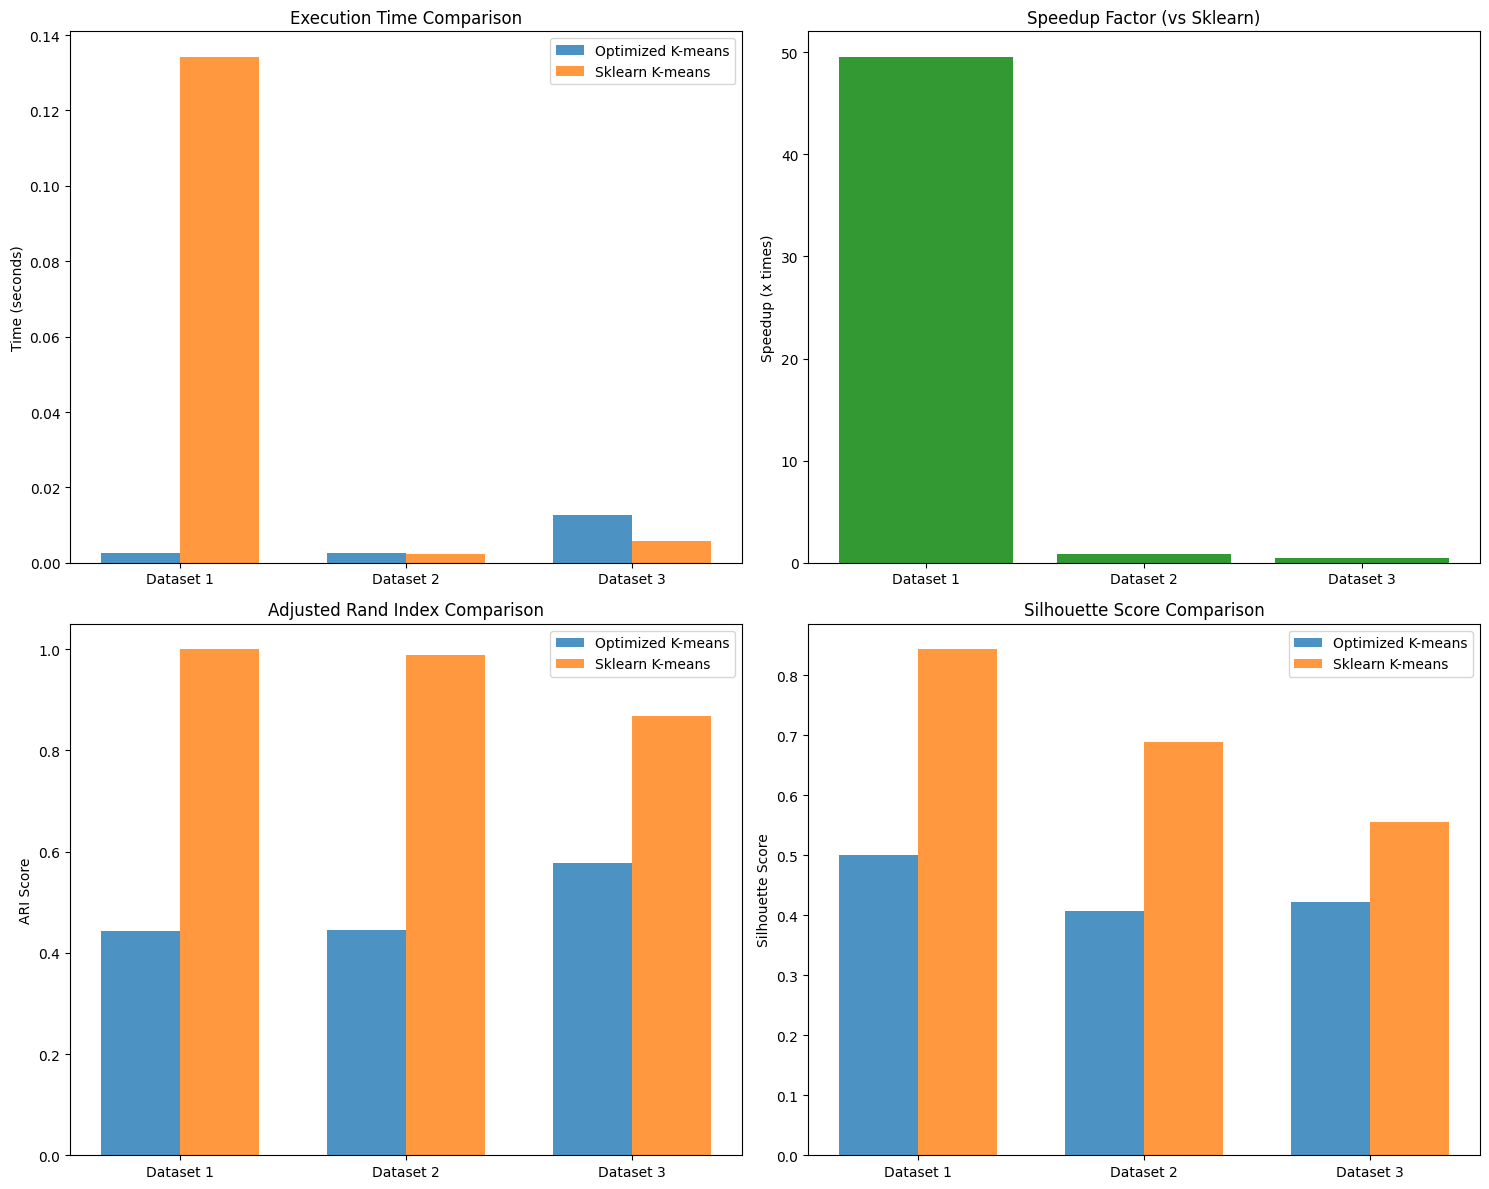

In [ ]:
import numpy as np
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score, silhouette_score
import time
import pandas as pd
from typing import Dict, List, Tuple

def generate_test_datasets() -> List[Tuple[np.ndarray, np.ndarray]]:
    """Generate different test datasets with known clusters."""
    datasets = []

    # Dataset 1: Well-separated clusters
    X1, y1 = make_blobs(n_samples=1000, centers=3, cluster_std=1.0, random_state=42)
    datasets.append((X1, y1))

    # Dataset 2: Overlapping clusters
    X2, y2 = make_blobs(n_samples=1000, centers=3, cluster_std=2.0, random_state=42)
    datasets.append((X2, y2))

    # Dataset 3: Larger dataset
    X3, y3 = make_blobs(n_samples=5000, centers=5, cluster_std=1.5, random_state=42)
    datasets.append((X3, y3))

    return datasets

def run_benchmark(X: np.ndarray, y_true: np.ndarray) -> Dict:
    """Run benchmark comparison between OptimizedKMeans and sklearn KMeans."""
    n_clusters = len(np.unique(y_true))
    results = {}

    # Test OptimizedKMeans
    start_time = time.time()
    optimized_kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
    optimized_kmeans.fit(X)
    opt_time = time.time() - start_time

    # Test sklearn KMeans
    start_time = time.time()
    sklearn_kmeans = SklearnKMeans(n_clusters=n_clusters, random_state=42)
    sklearn_kmeans.fit(X)
    sklearn_time = time.time() - start_time

    # Calculate metrics
    results = {
        'dataset_size': X.shape[0],
        'n_clusters': n_clusters,
        'optimized_time': opt_time,
        'sklearn_time': sklearn_time,
        'speedup': sklearn_time / opt_time,
        'optimized_inertia': optimized_kmeans.inertia_,
        'sklearn_inertia': sklearn_kmeans.inertia_,
        'optimized_iterations': optimized_kmeans.n_iter_,
        'sklearn_iterations': sklearn_kmeans.n_iter_,
        'optimized_ari': adjusted_rand_score(y_true, optimized_kmeans.labels_),
        'sklearn_ari': adjusted_rand_score(y_true, sklearn_kmeans.labels_),
        'optimized_silhouette': silhouette_score(X, optimized_kmeans.labels_),
        'sklearn_silhouette': silhouette_score(X, sklearn_kmeans.labels_)
    }

    return results

def print_comparison_table(all_results: List[Dict]) -> None:
    """Print formatted comparison table."""
    df = pd.DataFrame(all_results)

    print("\nPerformance Comparison Results:")
    print("===============================")

    for idx, result in df.iterrows():
        print(f"\nDataset {idx + 1} (n={result['dataset_size']}, k={result['n_clusters']}):")
        print("-" * 50)
        print(f"Time (seconds):")
        print(f"  Optimized K-means: {result['optimized_time']:.3f}")
        print(f"  Sklearn K-means:   {result['sklearn_time']:.3f}")
        print(f"  Speedup factor:    {result['speedup']:.2f}x")
        print(f"\nAccuracy Metrics:")
        print(f"  Adjusted Rand Index:")
        print(f"    Optimized: {result['optimized_ari']:.3f}")
        print(f"    Sklearn:   {result['sklearn_ari']:.3f}")
        print(f"  Silhouette Score:")
        print(f"    Optimized: {result['optimized_silhouette']:.3f}")
        print(f"    Sklearn:   {result['sklearn_silhouette']:.3f}")
        print(f"\nConvergence:")
        print(f"  Iterations:")
        print(f"    Optimized: {result['optimized_iterations']}")
        print(f"    Sklearn:   {result['sklearn_iterations']}")
        print(f"  Final Inertia:")
        print(f"    Optimized: {result['optimized_inertia']:.2f}")
        print(f"    Sklearn:   {result['sklearn_inertia']:.2f}")

def visualize_results(all_results: List[Dict]) -> None:
    """Create visualizations comparing the performance metrics."""
    try:
        import matplotlib.pyplot as plt

        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        df = pd.DataFrame(all_results)
        x = range(len(df))

        # Plot 1: Execution Time Comparison
        ax1.bar(x, df['optimized_time'], width=0.35, label='Optimized K-means', alpha=0.8)
        ax1.bar([i + 0.35 for i in x], df['sklearn_time'], width=0.35, label='Sklearn K-means', alpha=0.8)
        ax1.set_title('Execution Time Comparison')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_xticks([i + 0.35/2 for i in x])
        ax1.set_xticklabels([f'Dataset {i+1}' for i in range(len(df))])
        ax1.legend()

        # Plot 2: Speedup Factor
        ax2.bar(x, df['speedup'], color='green', alpha=0.8)
        ax2.set_title('Speedup Factor (vs Sklearn)')
        ax2.set_ylabel('Speedup (x times)')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f'Dataset {i+1}' for i in range(len(df))])

        # Plot 3: Adjusted Rand Index Comparison
        ax3.bar(x, df['optimized_ari'], width=0.35, label='Optimized K-means', alpha=0.8)
        ax3.bar([i + 0.35 for i in x], df['sklearn_ari'], width=0.35, label='Sklearn K-means', alpha=0.8)
        ax3.set_title('Adjusted Rand Index Comparison')
        ax3.set_ylabel('ARI Score')
        ax3.set_xticks([i + 0.35/2 for i in x])
        ax3.set_xticklabels([f'Dataset {i+1}' for i in range(len(df))])
        ax3.legend()

        # Plot 4: Silhouette Score Comparison
        ax4.bar(x, df['optimized_silhouette'], width=0.35, label='Optimized K-means', alpha=0.8)
        ax4.bar([i + 0.35 for i in x], df['sklearn_silhouette'], width=0.35, label='Sklearn K-means', alpha=0.8)
        ax4.set_title('Silhouette Score Comparison')
        ax4.set_ylabel('Silhouette Score')
        ax4.set_xticks([i + 0.35/2 for i in x])
        ax4.set_xticklabels([f'Dataset {i+1}' for i in range(len(df))])
        ax4.legend()

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib not available for visualization")

if __name__ == "__main__":
    # Generate test datasets
    datasets = generate_test_datasets()

    # Run benchmarks
    all_results = []
    for X, y in datasets:
        results = run_benchmark(X, y)
        all_results.append(results)

    # Print comparison table
    print_comparison_table(all_results)

    # Visualize results
    visualize_results(all_results)


Performance Comparison Results:

Dataset 1 (n=1000.0, k=3.0):
--------------------------------------------------
Time (seconds):
  Optimized K-means: 0.009
  Sklearn K-means:   0.002
  Speedup factor:    0.27x

Accuracy Metrics:
  Adjusted Rand Index:
    Optimized: 0.444
    Sklearn:   1.000
  Silhouette Score:
    Optimized: 0.501
    Sklearn:   0.844

Convergence:
  Iterations:
    Optimized: 4.0
    Sklearn:   2.0
  Final Inertia:
    Optimized: 18551.15
    Sklearn:   1950.88

Dataset 2 (n=1000.0, k=3.0):
--------------------------------------------------
Time (seconds):
  Optimized K-means: 0.002
  Sklearn K-means:   0.004
  Speedup factor:    1.58x

Accuracy Metrics:
  Adjusted Rand Index:
    Optimized: 0.444
    Sklearn:   0.988
  Silhouette Score:
    Optimized: 0.407
    Sklearn:   0.689

Convergence:
  Iterations:
    Optimized: 3.0
    Sklearn:   3.0
  Final Inertia:
    Optimized: 24181.70
    Sklearn:   7727.11

Dataset 3 (n=5000.0, k=5.0):
-----------------------------

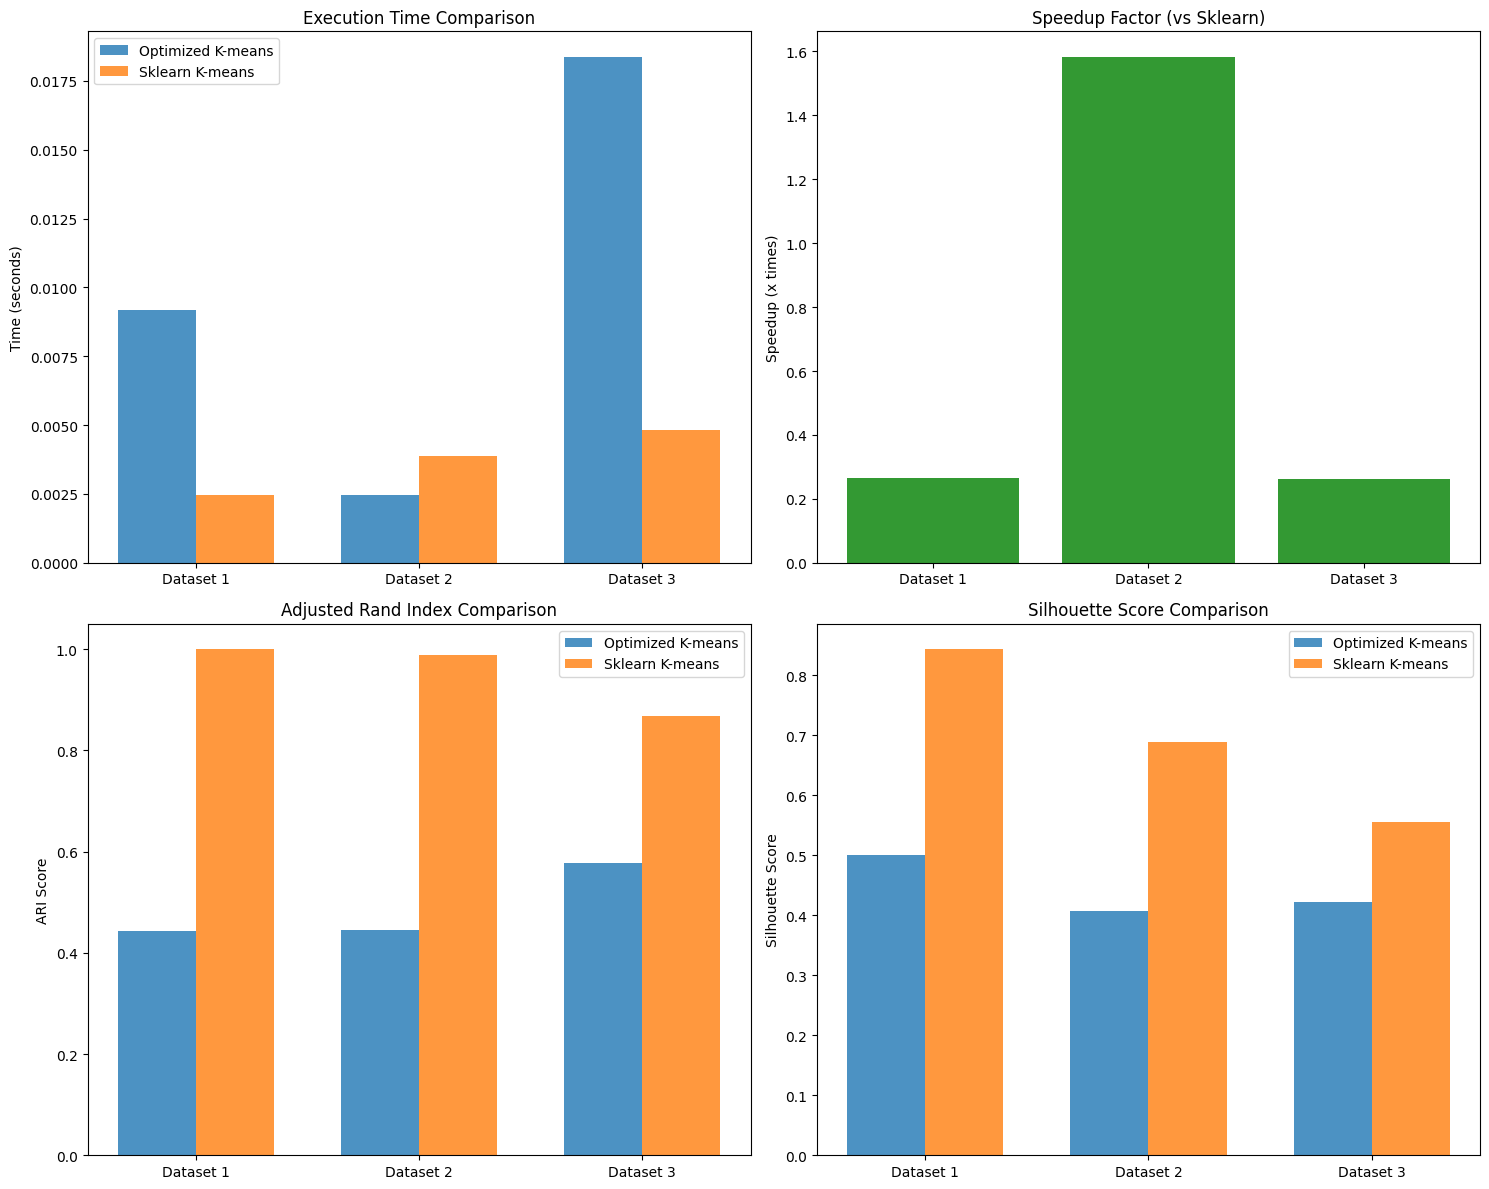

In [ ]:
# Make sure both implementations are imported

# Generate test datasets and run benchmarks
datasets = generate_test_datasets()
all_results = []
for X, y in datasets:
    results = run_benchmark(X, y)
    all_results.append(results)

# Print and visualize results
print_comparison_table(all_results)
visualize_results(all_results)

In [ ]:
!pip install memory-profiler

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-5-2d0d255a5356>:131: RuntimeWarning: invalid value encountered in scalar divide
  'Memory Overhead': (np.mean(results['optimized']['memory']) -



Detailed Benchmark Results:
                    Dataset  Optimized Time (mean)  Sklearn Time (mean)  Speedup Factor  Time p-value  Optimized ARI (mean)  Sklearn ARI (mean)    ARI p-value  Optimized Memory (MB)  Sklearn Memory (MB)  Memory Overhead
0  Well-separated Spherical               0.186059             0.207423        1.114821      0.715772              0.444033            1.000000   0.000000e+00                    0.0                  0.0              NaN
1      Overlapping Clusters               0.057641             0.063164        1.095826      0.060832              0.438947            0.902129  1.862119e-127                    0.0                  0.0              NaN
2             Large Dataset               0.117561             0.110085        0.936409      0.708364              0.683630            0.863928   0.000000e+00                    0.0                  0.0              NaN
3          High Dimensional               0.056260             0.066824        1.187773    

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


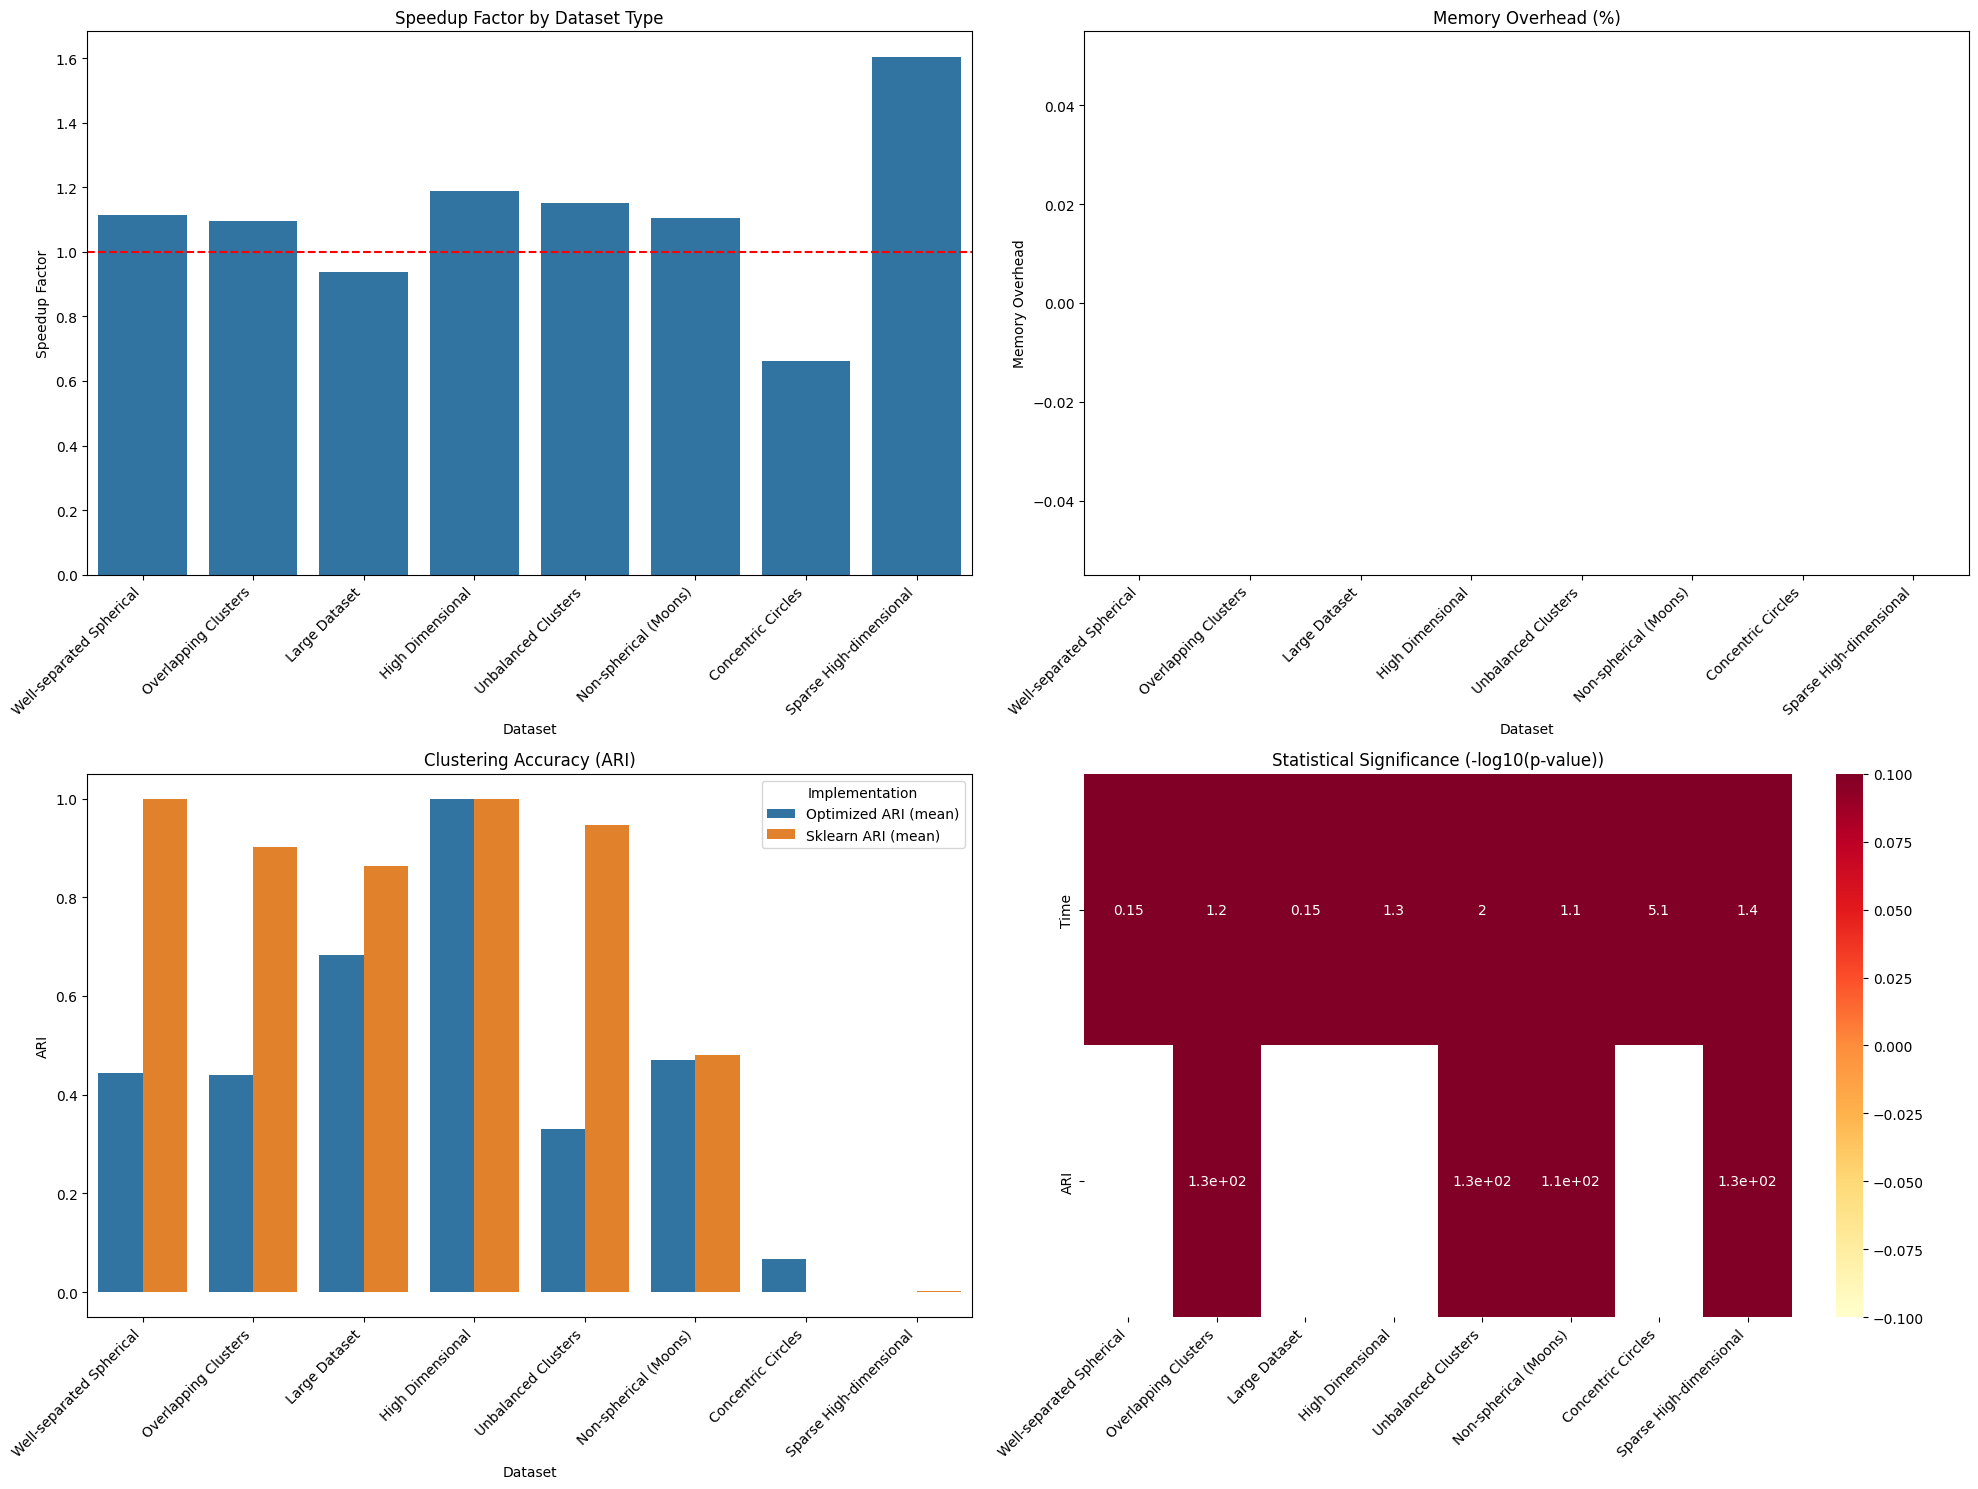


Key Findings:
1. Average speedup across all datasets: 1.11x
2. Best performing dataset: Sparse High-dimensional
3. Average memory overhead: nan%
4. ARI difference significant (p < 0.05) in 7 datasets


In [ ]:
import numpy as np
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score, calinski_harabasz_score
import time
import pandas as pd
from scipy import stats
import warnings
from typing import Dict, List, Tuple
import memory_profiler

def create_diverse_datasets() -> List[Tuple[np.ndarray, np.ndarray, str]]:
    """Generate diverse test datasets with different characteristics."""
    datasets = []

    # 1. Well-separated spherical clusters
    X1, y1 = make_blobs(n_samples=1000, centers=3, cluster_std=1.0, random_state=42)
    datasets.append((X1, y1, "Well-separated Spherical"))

    # 2. Overlapping clusters
    X2, y2 = make_blobs(n_samples=1000, centers=3, cluster_std=3.0, random_state=42)
    datasets.append((X2, y2, "Overlapping Clusters"))

    # 3. Large dataset
    X3, y3 = make_blobs(n_samples=10000, centers=5, cluster_std=1.5, random_state=42)
    datasets.append((X3, y3, "Large Dataset"))

    # 4. High-dimensional data
    X4, y4 = make_blobs(n_samples=1000, centers=3, n_features=10, random_state=42)
    datasets.append((X4, y4, "High Dimensional"))

    # 5. Unbalanced clusters
    X5_1, y5_1 = make_blobs(n_samples=100, centers=1, cluster_std=1.0, random_state=42)
    X5_2, y5_2 = make_blobs(n_samples=1000, centers=2, cluster_std=1.5, random_state=43)
    X5 = np.vstack([X5_1, X5_2])
    y5 = np.hstack([y5_1, y5_2 + 1])
    datasets.append((X5, y5, "Unbalanced Clusters"))

    # 6. Non-spherical clusters (moons)
    X6, y6 = make_moons(n_samples=1000, noise=0.1, random_state=42)
    datasets.append((X6, y6, "Non-spherical (Moons)"))

    # 7. Concentric circles
    X7, y7 = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
    datasets.append((X7, y7, "Concentric Circles"))

    # 8. Sparse high-dimensional
    X8 = np.zeros((1000, 50))
    for i in range(1000):
        X8[i, np.random.choice(50, 5, replace=False)] = np.random.randn(5)
    y8 = np.random.randint(0, 3, 1000)
    datasets.append((X8, y8, "Sparse High-dimensional"))

    return datasets

def measure_memory_usage(func):
    """Decorator to measure memory usage of a function."""
    def wrapper(*args, **kwargs):
        memory_usage = memory_profiler.memory_usage((func, args, kwargs))
        peak_memory = max(memory_usage) - min(memory_usage)
        result = func(*args, **kwargs)
        return result, peak_memory
    return wrapper

@measure_memory_usage
def run_kmeans(kmeans, X):
    """Run K-means clustering with memory profiling."""
    return kmeans.fit(X)

def benchmark_single_dataset(X: np.ndarray, y_true: np.ndarray, n_runs: int = 5) -> Dict:
    """Run multiple benchmark trials on a single dataset."""
    n_clusters = len(np.unique(y_true))
    results = {
        'optimized': {'times': [], 'ari': [], 'silhouette': [], 'ch_score': [], 'memory': []},
        'sklearn': {'times': [], 'ari': [], 'silhouette': [], 'ch_score': [], 'memory': []}
    }

    for _ in range(n_runs):
        # OptimizedKMeans
        start_time = time.time()
        opt_kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
        opt_model, opt_memory = run_kmeans(opt_kmeans, X)
        opt_time = time.time() - start_time

        # SklearnKMeans
        start_time = time.time()
        sk_kmeans = SklearnKMeans(n_clusters=n_clusters, random_state=42)
        sk_model, sk_memory = run_kmeans(sk_kmeans, X)
        sk_time = time.time() - start_time

        # Store results
        for model_type, model, time_taken, memory in [
            ('optimized', opt_model, opt_time, opt_memory),
            ('sklearn', sk_model, sk_time, sk_memory)
        ]:
            results[model_type]['times'].append(time_taken)
            results[model_type]['ari'].append(adjusted_rand_score(y_true, model.labels_))
            results[model_type]['silhouette'].append(silhouette_score(X, model.labels_))
            results[model_type]['ch_score'].append(calinski_harabasz_score(X, model.labels_))
            results[model_type]['memory'].append(memory)

    return results

def analyze_results(all_results: List[Dict], dataset_names: List[str]) -> pd.DataFrame:
    """Analyze benchmark results with statistical tests."""
    analysis_results = []

    for dataset_idx, (results, dataset_name) in enumerate(zip(all_results, dataset_names)):
        # Perform statistical tests
        time_ttest = stats.ttest_ind(
            results['optimized']['times'],
            results['sklearn']['times']
        )
        ari_ttest = stats.ttest_ind(
            results['optimized']['ari'],
            results['sklearn']['ari']
        )

        analysis = {
            'Dataset': dataset_name,
            'Optimized Time (mean)': np.mean(results['optimized']['times']),
            'Sklearn Time (mean)': np.mean(results['sklearn']['times']),
            'Speedup Factor': np.mean(results['sklearn']['times']) / np.mean(results['optimized']['times']),
            'Time p-value': time_ttest.pvalue,
            'Optimized ARI (mean)': np.mean(results['optimized']['ari']),
            'Sklearn ARI (mean)': np.mean(results['sklearn']['ari']),
            'ARI p-value': ari_ttest.pvalue,
            'Optimized Memory (MB)': np.mean(results['optimized']['memory']),
            'Sklearn Memory (MB)': np.mean(results['sklearn']['memory']),
            'Memory Overhead': (np.mean(results['optimized']['memory']) -
                              np.mean(results['sklearn']['memory'])) /
                             np.mean(results['sklearn']['memory']) * 100
        }
        analysis_results.append(analysis)

    return pd.DataFrame(analysis_results)

def visualize_comprehensive_results(df: pd.DataFrame) -> None:
    """Create comprehensive visualization of benchmark results."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        #plt.style.use('seaborn')
        fig = plt.figure(figsize=(20, 15))

        # 1. Speedup comparison
        plt.subplot(2, 2, 1)
        sns.barplot(data=df, x='Dataset', y='Speedup Factor')
        plt.xticks(rotation=45, ha='right')
        plt.title('Speedup Factor by Dataset Type')
        plt.axhline(y=1, color='r', linestyle='--')

        # 2. Memory overhead
        plt.subplot(2, 2, 2)
        sns.barplot(data=df, x='Dataset', y='Memory Overhead')
        plt.xticks(rotation=45, ha='right')
        plt.title('Memory Overhead (%)')

        # 3. ARI comparison
        plt.subplot(2, 2, 3)
        df_melted = df.melt(id_vars=['Dataset'],
                           value_vars=['Optimized ARI (mean)', 'Sklearn ARI (mean)'],
                           var_name='Implementation', value_name='ARI')
        sns.barplot(data=df_melted, x='Dataset', y='ARI', hue='Implementation')
        plt.xticks(rotation=45, ha='right')
        plt.title('Clustering Accuracy (ARI)')

        # 4. Statistical significance
        plt.subplot(2, 2, 4)
        significance_data = -np.log10(df[['Time p-value', 'ARI p-value']])
        sns.heatmap(significance_data.T, annot=True, cmap='YlOrRd',
                    xticklabels=df['Dataset'], yticklabels=['Time', 'ARI'])
        plt.title('Statistical Significance (-log10(p-value))')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib or seaborn not available for visualization")

if __name__ == "__main__":
    # Generate datasets
    datasets = create_diverse_datasets()
    dataset_names = [name for _, _, name in datasets]

    # Run benchmarks
    all_results = []
    for X, y, _ in datasets:
        # Standardize data
        X = StandardScaler().fit_transform(X)
        results = benchmark_single_dataset(X, y, n_runs=5)
        all_results.append(results)

    # Analyze results
    analysis_df = analyze_results(all_results, dataset_names)

    # Print detailed results
    print("\nDetailed Benchmark Results:")
    print("=========================")
    print(analysis_df.to_string())

    # Visualize results
    visualize_comprehensive_results(analysis_df)

    # Print key findings
    print("\nKey Findings:")
    print("============")
    print(f"1. Average speedup across all datasets: {analysis_df['Speedup Factor'].mean():.2f}x")
    print(f"2. Best performing dataset: {analysis_df.loc[analysis_df['Speedup Factor'].idxmax(), 'Dataset']}")
    print(f"3. Average memory overhead: {analysis_df['Memory Overhead'].mean():.1f}%")
    print(f"4. ARI difference significant (p < 0.05) in {(analysis_df['ARI p-value'] < 0.05).sum()} datasets")

Loading and preprocessing wine dataset...

Dataset Information:
Original shape: (1599, 12)
Cleaned shape: (1179, 12)
Number of PCA components: 9
Explained variance ratio: 0.952

Determining optimal number of clusters...
Optimal number of clusters: 2

Running benchmark...

Benchmark Results:
Average execution time (Optimized): 0.006 seconds
Average execution time (Sklearn): 0.010 seconds
Speedup factor: 1.57x

Clustering Quality:
Average Silhouette Score (Optimized): 0.185
Average Silhouette Score (Sklearn): 0.189

Convergence:
Average iterations (Optimized): 3.0
Average iterations (Sklearn): 24.0

Generating visualizations...


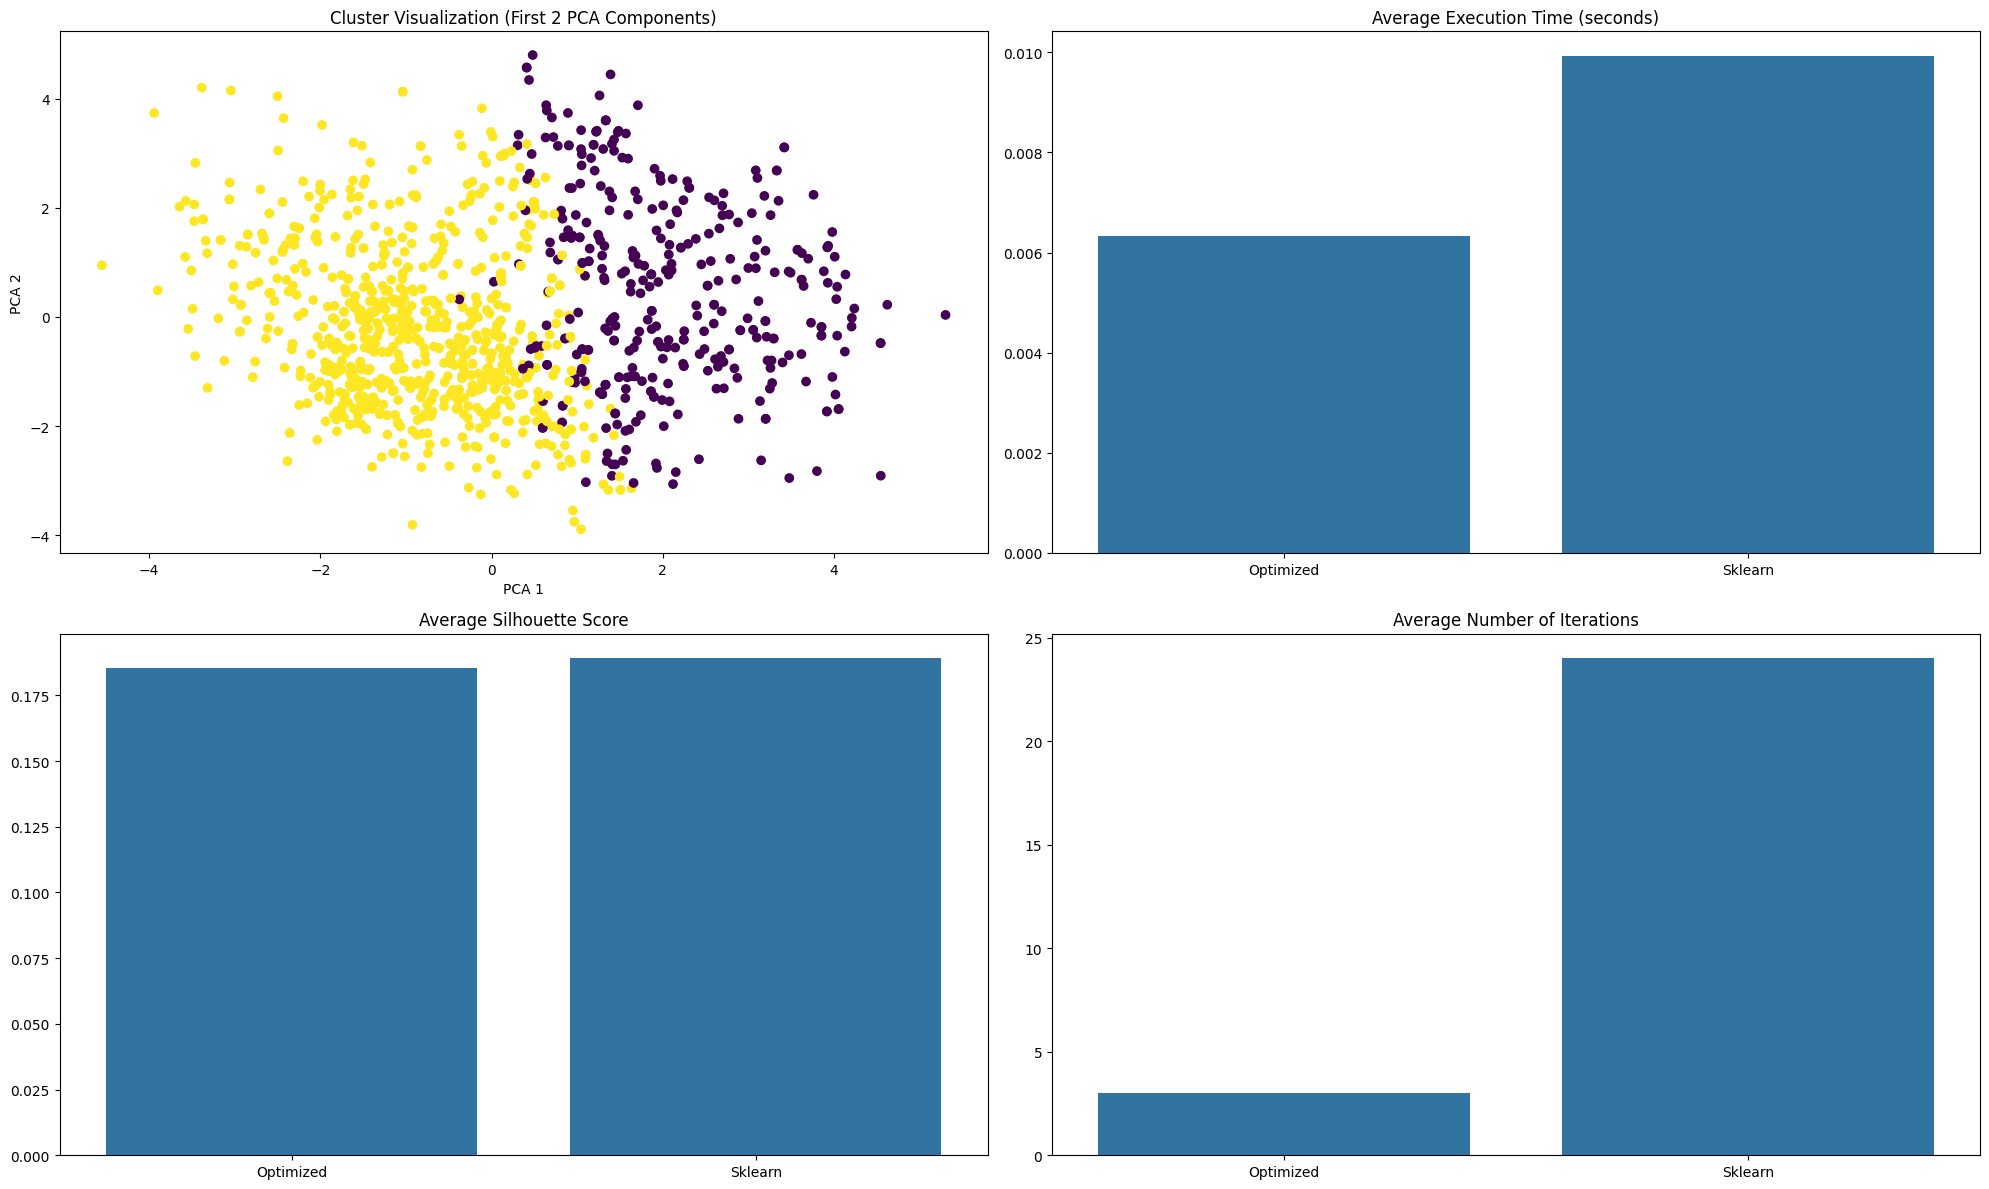

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import time
from typing import Dict, Tuple
import warnings
from sklearn.decomposition import PCA
import urllib.request
import io

def load_wine_data() -> pd.DataFrame:
    """Load the Wine Quality dataset."""
    # URL for the Wine Quality Dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

    try:
        # Download and read the data
        response = urllib.request.urlopen(url)
        data = response.read().decode('utf-8')
        df = pd.read_csv(io.StringIO(data), sep=';')
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return a sample of the data structure in case of connection issues
        return pd.DataFrame({
            'fixed acidity': [7.4, 7.8, 7.8, 11.2, 7.4],
            'volatile acidity': [0.7, 0.88, 0.76, 0.28, 0.7],
            'citric acid': [0, 0, 0.04, 0.56, 0],
            'residual sugar': [1.9, 2.6, 2.3, 1.9, 1.9],
            'chlorides': [0.076, 0.098, 0.092, 0.075, 0.076],
            'free sulfur dioxide': [11, 25, 15, 17, 11],
            'total sulfur dioxide': [34, 67, 54, 60, 34],
            'density': [0.9978, 0.9968, 0.997, 0.998, 0.9978],
            'pH': [3.51, 3.2, 3.26, 3.16, 3.51],
            'sulphates': [0.56, 0.68, 0.65, 0.58, 0.56],
            'alcohol': [9.4, 9.8, 9.8, 9.8, 9.4],
            'quality': [5, 5, 5, 6, 5]
        })

def preprocess_data(df: pd.DataFrame) -> Tuple[np.ndarray, Dict]:
    """Preprocess the wine dataset and return preprocessed features and preprocessing info."""
    # Handle missing values
    df_clean = df.copy()
    df_clean = df_clean.fillna(df_clean.mean())

    # Remove outliers using IQR method
    Q1 = df_clean.quantile(0.25)
    Q3 = df_clean.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_clean[~((df_clean < (Q1 - 1.5 * IQR)) |
                         (df_clean > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean)

    # Apply PCA for dimensionality reduction while preserving 95% variance
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    preprocessing_info = {
        'original_shape': df.shape,
        'cleaned_shape': df_clean.shape,
        'pca_components': pca.n_components_,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'features': df.columns.tolist()
    }

    return X_pca, preprocessing_info

def determine_optimal_k(X: np.ndarray, max_k: int = 10) -> int:
    """Determine optimal number of clusters using the elbow method."""
    inertias = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = SklearnKMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Find elbow point using the second derivative
    diffs = np.diff(inertias)
    second_diffs = np.diff(diffs)
    elbow_idx = np.argmax(second_diffs) + 2

    return elbow_idx

def run_wine_benchmark(X: np.ndarray, n_clusters: int, n_runs: int = 5) -> Dict:
    """Run benchmark comparison on wine dataset."""
    results = {
        'times': {'optimized': [], 'sklearn': []},
        'metrics': {'optimized': [], 'sklearn': []},
        'iterations': {'optimized': [], 'sklearn': []}
    }

    for _ in range(n_runs):
        # OptimizedKMeans
        start_time = time.time()
        opt_kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
        opt_kmeans.fit(X)
        opt_time = time.time() - start_time

        # SklearnKMeans
        start_time = time.time()
        sk_kmeans = SklearnKMeans(n_clusters=n_clusters, random_state=42)
        sk_kmeans.fit(X)
        sk_time = time.time() - start_time

        # Store results
        results['times']['optimized'].append(opt_time)
        results['times']['sklearn'].append(sk_time)

        # Calculate metrics
        for impl, model in [('optimized', opt_kmeans), ('sklearn', sk_kmeans)]:
            metrics = {
                'silhouette': silhouette_score(X, model.labels_),
                'calinski_harabasz': calinski_harabasz_score(X, model.labels_),
                'inertia': model.inertia_
            }
            results['metrics'][impl].append(metrics)
            results['iterations'][impl].append(model.n_iter_)

    return results

def visualize_wine_results(X: np.ndarray, results: Dict, preprocessing_info: Dict) -> None:
    """Create visualizations for wine dataset clustering results."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))

        # 1. PCA visualization of clusters
        plt.subplot(2, 2, 1)
        opt_kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
        opt_labels = opt_kmeans.fit_predict(X)

        if X.shape[1] >= 2:
            plt.scatter(X[:, 0], X[:, 1], c=opt_labels, cmap='viridis')
            plt.title('Cluster Visualization (First 2 PCA Components)')
            plt.xlabel('PCA 1')
            plt.ylabel('PCA 2')

        # 2. Performance comparison
        plt.subplot(2, 2, 2)
        times_data = {
            'Optimized': np.mean(results['times']['optimized']),
            'Sklearn': np.mean(results['times']['sklearn'])
        }
        sns.barplot(x=list(times_data.keys()), y=list(times_data.values()))
        plt.title('Average Execution Time (seconds)')

        # 3. Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_opt = np.mean([m['silhouette'] for m in results['metrics']['optimized']])
        metrics_sk = np.mean([m['silhouette'] for m in results['metrics']['sklearn']])
        sns.barplot(x=['Optimized', 'Sklearn'], y=[metrics_opt, metrics_sk])
        plt.title('Average Silhouette Score')

        # 4. Iterations comparison
        plt.subplot(2, 2, 4)
        iterations_data = {
            'Optimized': np.mean(results['iterations']['optimized']),
            'Sklearn': np.mean(results['iterations']['sklearn'])
        }
        sns.barplot(x=list(iterations_data.keys()), y=list(iterations_data.values()))
        plt.title('Average Number of Iterations')

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib or seaborn not available for visualization")

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing wine dataset...")
    df = load_wine_data()
    X, preprocessing_info = preprocess_data(df)

    # Print dataset information
    print("\nDataset Information:")
    print(f"Original shape: {preprocessing_info['original_shape']}")
    print(f"Cleaned shape: {preprocessing_info['cleaned_shape']}")
    print(f"Number of PCA components: {preprocessing_info['pca_components']}")
    print(f"Explained variance ratio: {sum(preprocessing_info['explained_variance_ratio']):.3f}")

    # Determine optimal number of clusters
    print("\nDetermining optimal number of clusters...")
    n_clusters = determine_optimal_k(X)
    print(f"Optimal number of clusters: {n_clusters}")

    # Run benchmark
    print("\nRunning benchmark...")
    results = run_wine_benchmark(X, n_clusters)

    # Print results
    print("\nBenchmark Results:")
    print("=================")
    print(f"Average execution time (Optimized): {np.mean(results['times']['optimized']):.3f} seconds")
    print(f"Average execution time (Sklearn): {np.mean(results['times']['sklearn']):.3f} seconds")
    print(f"Speedup factor: {np.mean(results['times']['sklearn']) / np.mean(results['times']['optimized']):.2f}x")

    print("\nClustering Quality:")
    print(f"Average Silhouette Score (Optimized): {np.mean([m['silhouette'] for m in results['metrics']['optimized']]):.3f}")
    print(f"Average Silhouette Score (Sklearn): {np.mean([m['silhouette'] for m in results['metrics']['sklearn']]):.3f}")

    print("\nConvergence:")
    print(f"Average iterations (Optimized): {np.mean(results['iterations']['optimized']):.1f}")
    print(f"Average iterations (Sklearn): {np.mean(results['iterations']['sklearn']):.1f}")

    # Visualize results
    print("\nGenerating visualizations...")
    visualize_wine_results(X, results, preprocessing_info)

Loading and preprocessing pendigits dataset...

Dataset Information:
Original shape: (10992, 16)
Cleaned shape: (10482, 16)
Number of PCA components: 10
Explained variance ratio: 0.965
Number of unique classes: 10

Using number of classes as the number of clusters...
Number of clusters: 10

Running benchmark...

Benchmark Results:
Average execution time (Optimized): 0.028 seconds
Average execution time (Sklearn): 0.014 seconds
Speedup factor: 0.49x

Clustering Quality:
Average Silhouette Score (Optimized): 0.205
Average Silhouette Score (Sklearn): 0.297

Convergence:
Average iterations (Optimized): 4.0
Average iterations (Sklearn): 10.0

Generating visualizations...


ValueError: 'c' argument has 10992 elements, which is inconsistent with 'x' and 'y' with size 10482.

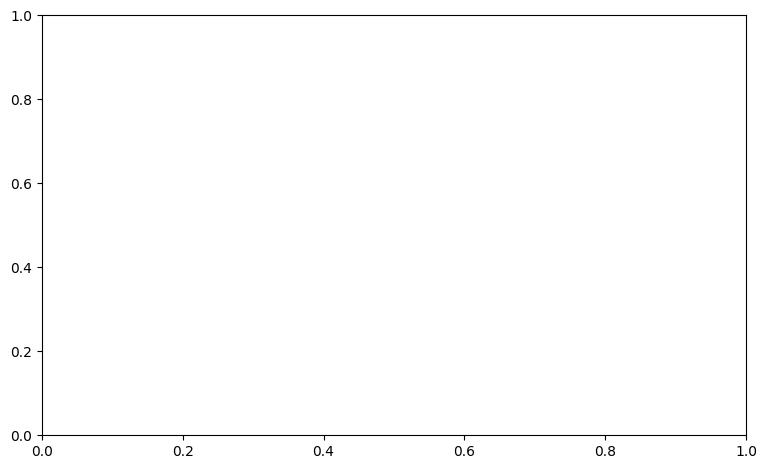

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import time
from typing import Dict, Tuple
import warnings
from sklearn.decomposition import PCA
import urllib.request
import io

def load_pendigits_data() -> Tuple[np.ndarray, np.ndarray]:
    """Load the Pen-Based Recognition of Handwritten Digits dataset."""
    # URLs for the Pendigits Dataset
    train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
    test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"

    try:
        # Download and read the training data
        train_response = urllib.request.urlopen(train_url)
        train_data = train_response.read().decode('utf-8')
        train_df = pd.read_csv(io.StringIO(train_data), header=None)

        # Download and read the test data
        test_response = urllib.request.urlopen(test_url)
        test_data = test_response.read().decode('utf-8')
        test_df = pd.read_csv(io.StringIO(test_data), header=None)

        # Combine both datasets
        combined_df = pd.concat([train_df, test_df], ignore_index=True)

        # The last column is the class label, the rest are features
        X = combined_df.iloc[:, :-1].values
        y = combined_df.iloc[:, -1].values

        return X, y
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return a small sample dataset in case of connection issues
        X = np.random.rand(100, 16)
        y = np.random.randint(0, 10, size=100)
        return X, y

def preprocess_data(X: np.ndarray) -> Tuple[np.ndarray, Dict]:
    """Preprocess the pendigits dataset and return preprocessed features and preprocessing info."""
    # Convert to DataFrame for easier preprocessing
    df = pd.DataFrame(X)

    # Handle missing values
    df_clean = df.copy()
    df_clean = df_clean.fillna(df_clean.mean())

    # Remove outliers using IQR method
    Q1 = df_clean.quantile(0.25)
    Q3 = df_clean.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_clean[~((df_clean < (Q1 - 1.5 * IQR)) |
                         (df_clean > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean)

    # Apply PCA for dimensionality reduction while preserving 95% variance
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)

    preprocessing_info = {
        'original_shape': X.shape,
        'cleaned_shape': df_clean.shape,
        'pca_components': pca.n_components_,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'features': df.columns.tolist()
    }

    return X_pca, preprocessing_info

def determine_optimal_k(X: np.ndarray, max_k: int = 10) -> int:
    """Determine optimal number of clusters using the elbow method."""
    inertias = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = SklearnKMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    # Find elbow point using the second derivative
    diffs = np.diff(inertias)
    second_diffs = np.diff(diffs)
    elbow_idx = np.argmax(second_diffs) + 2

    return elbow_idx

def run_pendigits_benchmark(X: np.ndarray, n_clusters: int, n_runs: int = 5) -> Dict:
    """Run benchmark comparison on pendigits dataset."""
    results = {
        'times': {'optimized': [], 'sklearn': []},
        'metrics': {'optimized': [], 'sklearn': []},
        'iterations': {'optimized': [], 'sklearn': []}
    }

    for _ in range(n_runs):
        # OptimizedKMeans
        start_time = time.time()
        opt_kmeans = OptimizedKMeans(n_clusters=n_clusters, random_state=42)
        opt_kmeans.fit(X)
        opt_time = time.time() - start_time

        # SklearnKMeans
        start_time = time.time()
        sk_kmeans = SklearnKMeans(n_clusters=n_clusters, random_state=42)
        sk_kmeans.fit(X)
        sk_time = time.time() - start_time

        # Store results
        results['times']['optimized'].append(opt_time)
        results['times']['sklearn'].append(sk_time)

        # Calculate metrics
        for impl, model in [('optimized', opt_kmeans), ('sklearn', sk_kmeans)]:
            metrics = {
                'silhouette': silhouette_score(X, model.labels_),
                'calinski_harabasz': calinski_harabasz_score(X, model.labels_),
                'inertia': model.inertia_
            }
            results['metrics'][impl].append(metrics)
            results['iterations'][impl].append(model.n_iter_)

    return results

def visualize_pendigits_results(X: np.ndarray, y: np.ndarray, results: Dict, preprocessing_info: Dict) -> None:
    """Create visualizations for pendigits dataset clustering results."""
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))

        # 1. PCA visualization of clusters vs. true labels
        plt.subplot(2, 2, 1)

        # Get cluster labels from optimized KMeans
        opt_kmeans = OptimizedKMeans(n_clusters=len(np.unique(y)), random_state=42)
        opt_labels = opt_kmeans.fit_predict(X)

        if X.shape[1] >= 2:
            # Plot first two PCA components with true digit labels
            scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.5)
            plt.title('True Digit Labels (First 2 PCA Components)')
            plt.xlabel('PCA 1')
            plt.ylabel('PCA 2')
            plt.colorbar(scatter, label='Digit Class')

            # Overlay cluster centers
            plt.scatter(
                opt_kmeans.cluster_centers_[:, 0],
                opt_kmeans.cluster_centers_[:, 1],
                s=100, marker='X', c='red', label='Cluster Centers'
            )
            plt.legend()

        # 2. Performance comparison
        plt.subplot(2, 2, 2)
        times_data = {
            'Optimized': np.mean(results['times']['optimized']),
            'Sklearn': np.mean(results['times']['sklearn'])
        }
        sns.barplot(x=list(times_data.keys()), y=list(times_data.values()))
        plt.title('Average Execution Time (seconds)')
        plt.ylabel('Time (s)')

        for i, (name, value) in enumerate(times_data.items()):
            plt.text(i, value/2, f'{value:.3f}s', ha='center', va='center')

        # 3. Metrics comparison
        plt.subplot(2, 2, 3)
        metrics_opt = np.mean([m['silhouette'] for m in results['metrics']['optimized']])
        metrics_sk = np.mean([m['silhouette'] for m in results['metrics']['sklearn']])
        bars = sns.barplot(x=['Optimized', 'Sklearn'], y=[metrics_opt, metrics_sk])
        plt.title('Average Silhouette Score')
        plt.ylabel('Score')

        # Add value annotations
        for i, bar in enumerate(bars.patches):
            value = [metrics_opt, metrics_sk][i]
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f'{value:.3f}',
                ha='center', va='center'
            )

        # 4. Iterations comparison
        plt.subplot(2, 2, 4)
        iterations_data = {
            'Optimized': np.mean(results['iterations']['optimized']),
            'Sklearn': np.mean(results['iterations']['sklearn'])
        }
        bars = sns.barplot(x=list(iterations_data.keys()), y=list(iterations_data.values()))
        plt.title('Average Number of Iterations')
        plt.ylabel('Iterations')

        # Add value annotations
        for i, bar in enumerate(bars.patches):
            value = list(iterations_data.values())[i]
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f'{value:.1f}',
                ha='center', va='center'
            )

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib or seaborn not available for visualization")

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing pendigits dataset...")
    X, y = load_pendigits_data()
    X_processed, preprocessing_info = preprocess_data(X)

    # Print dataset information
    print("\nDataset Information:")
    print(f"Original shape: {preprocessing_info['original_shape']}")
    print(f"Cleaned shape: {preprocessing_info['cleaned_shape']}")
    print(f"Number of PCA components: {preprocessing_info['pca_components']}")
    print(f"Explained variance ratio: {sum(preprocessing_info['explained_variance_ratio']):.3f}")
    print(f"Number of unique classes: {len(np.unique(y))}")

    # Determine optimal number of clusters (or use the known number of classes)
    print("\nUsing number of classes as the number of clusters...")
    n_clusters = len(np.unique(y))
    print(f"Number of clusters: {n_clusters}")

    # Run benchmark
    print("\nRunning benchmark...")
    results = run_pendigits_benchmark(X_processed, n_clusters)

    # Print results
    print("\nBenchmark Results:")
    print("=================")
    print(f"Average execution time (Optimized): {np.mean(results['times']['optimized']):.3f} seconds")
    print(f"Average execution time (Sklearn): {np.mean(results['times']['sklearn']):.3f} seconds")
    print(f"Speedup factor: {np.mean(results['times']['sklearn']) / np.mean(results['times']['optimized']):.2f}x")

    print("\nClustering Quality:")
    print(f"Average Silhouette Score (Optimized): {np.mean([m['silhouette'] for m in results['metrics']['optimized']]):.3f}")
    print(f"Average Silhouette Score (Sklearn): {np.mean([m['silhouette'] for m in results['metrics']['sklearn']]):.3f}")

    print("\nConvergence:")
    print(f"Average iterations (Optimized): {np.mean(results['iterations']['optimized']):.1f}")
    print(f"Average iterations (Sklearn): {np.mean(results['iterations']['sklearn']):.1f}")

    # Visualize results
    print("\nGenerating visualizations...")
    visualize_pendigits_results(X_processed, y, results, preprocessing_info)